# Klasyfikacja

# Autorzy

Adam Dohojda, Kacper Kiereś, Dawid Koceniak, Wiktoria Stęczna

Import bibliotek

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

Wczytywanie danych

In [45]:
df = pd.read_excel('rice.xlsx', header=None)
X = df.loc[1:, :6].values
y = df.loc[1:, 7].values

Używając obiektu LabelEncoder, przekształcamy etykiety klas na liczby całkowite

In [46]:
le = LabelEncoder()
y = le.fit_transform(y)
print("Class labels: ", le.classes_)

Class labels:  ['Cammeo' 'Osmancik']


In [47]:
le.transform(['Cammeo', 'Osmancik'])

array([0, 1])

Dzielenie zbioru danych na próbę treningową (80% danych) i próbę testową (20% danych).

In [48]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.2, 
                     stratify = y,
                     random_state = 0)

In [49]:
print('Labels counts in y: ', np.bincount(y))
print('Labels counts in y_train: ', np.bincount(y_train))
print('Labels counts in y_test: ', np.bincount(y_test))

Labels counts in y:  [1630 2180]
Labels counts in y_train:  [1304 1744]
Labels counts in y_test:  [326 436]


Standaryzacja zmiennych

In [50]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

Budowanie perecptrona do określneia tempa uczenia się

In [51]:
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [52]:
y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 82


In [53]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.892


In [54]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # Setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<', '>', 'D', 'P', 'X', '*')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan', 'orange', 'purple', 'pink', 'yellow', 'black')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # Plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')


### Łączenie transformatorów i estymatorów w pipelinie
Normalizujemy kolumny w zbiorze danych za pomocą `StandardScaler`, kompresujemy dane do dwuwymiarowej podprzestrzeni za pomocą `PCA`. a następnie przekazujemy je do klasyfikatora regresji logistycznej `LogisticRegression`, za pomocą funkcji `make_pipeline`.

In [55]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components = 2),
                        LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc: .3f}')

Test accuracy:  0.923


Funkcja `make_pipeline` pobiera dowolną liczbę transformatorów scikit-learn, a następnie estymator scikit-learn, który implementuje metody `fit` oraz `predict`.
W powyższym zapisie, dostarczyliśmy dwa transformatory scikit-learn - `StandardScaler` i `PCA` oraz estymator `LogisticRegression` jako dane wejściowe do funkcji `make_pipeline`, która konstruuje obiekt scikit-learn `Pipeline` z tych obiektów.
Na końcu zwracamy prognozę na podstawie przekształconych danych.


### Walidacja krzyżowa jako ocena wydajności modelu

Walidacja krzyżowa pomaga nam uzyskać wiarygodne szacunki wydajności ogólnej modelu, czyli tego, jak dobrze model radzi sobie z niewidocznymi danymi.

W k-krotnej walidacji krzyżowej losowo dzielimy zbiór danych treningowych na $k$ warstw (folds) bez zastępowania.
W tym przypadku $k-1$ warstw, tzw. warstw treningowych jest używanych do szkolenia modelu, a jedna warstwa tzw. warstwa testowa jest używana do oceny wydajności.

Procedura jest powtarzana $k$ razy, aby uzyskać $k$ modeli i oszacowań wydajności.


Niewielkim ulepszeniem jest stosunku do standardowego podejścia k-krotnej walidacji krzyżowej jest warstwowa k-kronta walidacja krzyżowa (stratified k-fold cross-validation), która może przynieść lepsze szacunki odchylenia i wariancji, szczególnie w przypadkach nierównych proporcji klas, co zostało również wykazane w tym samym badaniu Rona Kohaviego.

W warstwowej walidacji krzyżowej  proporcje etykiet klas są zachowane w każdym skupieniu, aby zapewnić, każde skupienie jest reprezentatywne dla udziału klas w zestawie danych treningowych.

Można to zilustrować za pomocą iteratora `StratifiedKFold` w scikit-learn: 

In [56]:
kfold = StratifiedKFold(n_splits = 10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f'Fold: {k+1:02d}, '
          f'Class distr.: {np.bincount(y_train[train])}, '
          f'Acc.: {score:.3f}')

Fold: 01, Class distr.: [1174 1569], Acc.: 0.928
Fold: 02, Class distr.: [1174 1569], Acc.: 0.938
Fold: 03, Class distr.: [1174 1569], Acc.: 0.908
Fold: 04, Class distr.: [1174 1569], Acc.: 0.918
Fold: 05, Class distr.: [1173 1570], Acc.: 0.915
Fold: 06, Class distr.: [1173 1570], Acc.: 0.948
Fold: 07, Class distr.: [1173 1570], Acc.: 0.921
Fold: 08, Class distr.: [1173 1570], Acc.: 0.915
Fold: 09, Class distr.: [1174 1570], Acc.: 0.928
Fold: 10, Class distr.: [1174 1570], Acc.: 0.914


Tworzymy obiekt `StratifiedKFold` z dziesięcioma podziałami (10-krotna walidacja krzyżowa).

Pętla `for` iteruje po podziałach stworzonych przez `StratifiedKFold`.
W każdej z niej:
- Dopasowywujemy model `pipe_lr` do danych treningowych z bieżącego podziału (`X_train[train]`, `y_train[train]`).
- Obliczamy dokładność (accuracy) modelu na danych testowych z bieżącego podziału
- Wyświetlamy informacje o numerze podziału, rozkłądzie klas w zbioerze treningowym oraz dokładności klasyfikacji na zbiorze testowym.

In [57]:
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nCV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')


CV accuracy: 0.923 +/- 0.011


Chociaż poprzedni przykład kodu był przydatny do zilustrowania, jak działa k-krotna walidacja krzyżowa, scikitlearn implementuje również scorer k-krotnej walidacji krzyżowej, który pozwala nam ocenić nasz model za pomocą
k-krotnej walidacji krzyżowej:

In [58]:
scores = cross_val_score(estimator = pipe_lr,
                         X = X_train,
                         y = y_train,
                         cv = 10,
                         n_jobs = 1)
print(f'CV accuracy scores: {scores}')
print(f'CV accuracy scores: {np.mean(scores):.3f}'
      f' +/- {np.std(scores):.3f}')

CV accuracy scores: [0.92786885 0.93770492 0.90819672 0.91803279 0.9147541  0.94754098
 0.92131148 0.9147541  0.92763158 0.91447368]
CV accuracy scores: 0.923 +/- 0.011


Niezwykle przedatną cechą podejścia `cross_val_score` jest to, że możemy rozdzielić ocenę różnych podziałów na wiele procesów centralnych (CPU) na naszej maszynie. `n_jobs` oznacza liczbę zadań do uruchomienia równolegle. Jeśli ustawimy parametr `n_jobs` na 1, tylko jeden proces zostanie użyty do oceny wyników, tak jak w naszym poprzednim przykładzie `StratifiedKFold`. 
Jednak ustawiając `n_jobs` na 2, możemy rozdzielić 10 rund walidacji krzyżowej na dwie jednoski CPU (jeśli są dostępne na naszej maszynie). 

### Diagnozowanie problemów z odchyleniem i wariancją za pomnocą krzywych uczenia się

W tym części przedstawiamy działanie krzywej uczenia się i krzywej walidacji do zdiagnozowania. Przyjrzymy się, czy algorytm ma problem z nadmiernym dopasowaniem (wysoka wariancja) lub też niedostatecznym dopasowaniem (wysokie odchylenie).

Jeśli model jest zby złożony dla danego zbioru danych treningowych - model ma wtedy tendencję do nadmiernego dopasowywania danych szkoleniowych i nie uogólnia się dobrze na niewidoczne dane. 

Często pomocne może być zebranie większej liczby przykładów szkoleniowych, aby zmniejszyć stopień nadmiernego dopasowania.

Jednak w praktyce gromadzenie większej ilości danych może być często bardzo kosztowne lub po prostu niewykonalne. 

Poprzez wykreślenie dokładności modelu treningowego i walidacyjnego jako funkcji wielkości zbioru danych treningowych, możemy łatwo wykryć, czy model cierpi z powodu dużej wariancji lub dużej stronniczości i czy zebranie większej ilości danych może pomóc w rozwiązaniu tego problemu.


Zobaczmy, jak możemy użyć funkcji krzywej uczenia się z scikit-learn do oceny modelu:

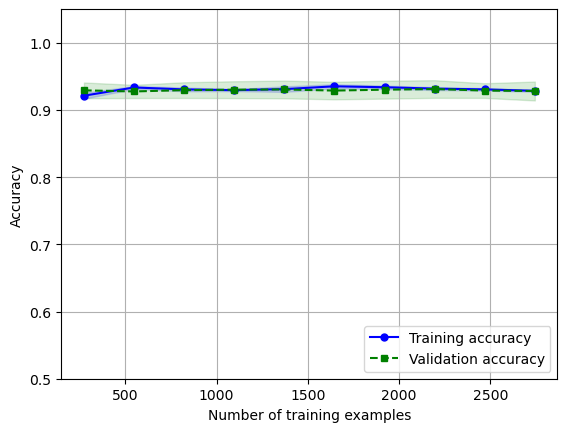

In [59]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2',
                                           max_iter=10000))
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lr,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(
                       0.1, 1.0, 10),
                       cv=10,
                       n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.05])
plt.show()


Przekazaliśmy `max_iter = 10000` jako dodatkowy argument, podczas tworzenia instancji obiektu `LogisticRegression` (który domyślnie używa 1000 iteracji), aby uniknąć problemów ze zbieżnością dla mniejszych rozmiarów zbiorów danych lub ekstremalnych wartości parametrów regularyzacji.

Za pomocą parametru `train_sizes` w funkcji `learning_curve` możemy kontrolować bezwzględną lub względną liczbę przykładów treningowych, które są używane do generowania krzywych uczenia się.

Tutaj ustaliliśmy `train_sizes = np.linspace(0.1,1.0,10)`, aby użyć 10 równomiernie rozmieszczonych względnych przedziałów dla rozmiarów zbioru danych treningowych. 

Domyślnie funkcja `learning_curve` wykorzystuje k-krotną waldację krzyżową do obliczenia dokładności walidacji krzyżowej klasyfikatora, a my ustawiamy $k = 10$ za pomocą parametru `cv` dla 10-krotnej warstwowej walidacji krzyżowej.

Następnie po prostu obliczamy średnią dokładność na podstawie zwróconych zweryfikowanych krzyżowo wyników treningowych i testowych dla różnych rozmiarów zbioru danych treningowych, które wykreśliliśmy za pomocą funkcji wykresu `Matplotlib`. 

Ponadto dodaliśmy odchylenie standardowe średniej dokładności do wykresu za pomocą funkcji `fill_between` aby wskazać wariancję oszacowania.

Jak widzimy na poprzednim wykresie krzywej uczenia, nasz model radzi sobie bardzo dobrze zarówno na zbiorze danych treningowych, jak i walidacyjnych.

### Rozwiązanie problemu nadmiernego i niedostatecznego dopasowania za pomocą krzywych walidacji

Krzywe walidacyjne są przydatnym narzędziem do poprawy wydajności modelu poprzez rozwiązywanie problemów takich jak nadmierne lub niedostateczne dopasowanie.

Krzywe walidacji są powiązane z krzywymi uczenia się, ale zamiast wykreślać jako funkcji wielkości próby, zmieniamy wartości parametrów modelu, na przykład odwrotny parametr regularyzacji, C, w regresji logistycznej.

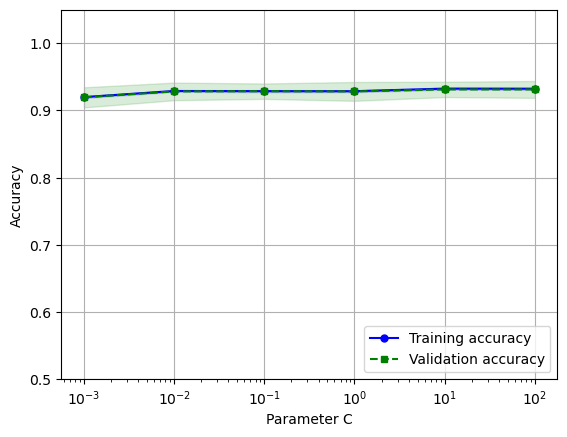

In [60]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator = pipe_lr,
    X = X_train,
    y = y_train,
    param_name = 'logisticregression__C',
    param_range = param_range,
    cv = 10)
train_mean = np.mean(train_scores , axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)
plt.plot(param_range, train_mean, color = 'blue',
         marker = 'o', markersize = 5, 
         label = 'Training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha = 0.15,
                 color = 'blue')
plt.plot(param_range, test_mean,
         color = 'green', linestyle = '--',
         marker = 's', markersize = 5,
         label = 'Validation accuracy')
plt.fill_between(param_range,
          test_mean + test_std,
          test_mean - test_std,
          alpha = 0.15, color = 'green')
plt.grid()
plt.xscale('log')
plt.legend(loc = 'lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.05])
plt.show()

Podobnie jak funkcja `learning_curve`, funkcja `validation_curve` domyślnie wykorzystuje warstwową k-krotną walidację krzyżową do oszacowania wydajności klasyfikatora.

Wewnątrz funkcji `validation_curve` określiliśmy parametr, który chcieliśmy ocenić. W tym przypadku jest to `C`, odwrotny parametr regularyzacji klasyfikatora `LogisticRegression`, który zapisaliśmy jako `logisticregression__C`.

Aby uzyskać dostęp do obiektu `LogisticRegression` wewnątrz potoku scikit-learn dla określonego zakresu wartości, który ustawiliśmy za pomocą parametru `param_range`.

Podobnie jak w przykładzie krzywej uczenia się w poprzedniej sekcji, wykreśliliśmy średnią dokładność treningu i walidacji krzyżowej oraz odpowiadające im odchylenia standardowe.

Widzimy, że dla dowolnego C, model dobrze dopasowywuje się do danych.

### Dostrajanie modeli uczenia maszynowego poprzez przeszukiwanie sietki (Grid Search)

Wykorzystamy teraz technikę optymalizacji hiperparametrów (parametry algorytmu uczącego poddane osobnej optymalizacji) zwanej przeszukiwaniem siatki (**Grid Search**), która może dodatkowo pomóc poprawić wydajność modelu, poprzez znalezienie ich optymalnej kombinacji wartości.

Działanie Grid Searchu jest następujące: jest to paradygmat brutalnego wyszukiwania wyczerpującego, w którym określamy listę wartości dla różnych hiperparametrów, a komputer ocenia wydajność modelu dla każdej kombinacji, aby uzyskać optymalną kombinację wartości z tego zestawu.

In [61]:
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state = 1))
param_range = [0.001, 0.01, 0.1,
               1.0, 10.0, 100.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
               {'svc__C': param_range,
                'svc__gamma': param_range,
                'svc__kernel':['rbf']}]
gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10,
                  refit = True,
                  n_jobs = -1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9314236410698877
{'svc__C': 10.0, 'svc__kernel': 'linear'}


Zainicjowaliśmy obiekt `GridSearchCV` z modułu `sklearn.model_selection` do trenowania i dostrajania pipeline'u `SVM`.

Ustawiliśmy parametr `param_grid` obiektu `GridSearchCV` na listę słowników, aby określić parametry, które chcemy dostroić. 

W przypadku liniowej `SVM` oceniliśmy tylko odwrotny parametr regularyzacji, `C`; w przypadku `SVM` z jądrem funkcji radialnej `(RBF)` dostroiliśmy zarówno parametry `svc__C`, jak i `svc__gamma`.

Należy zauważyć, że parametr `svc__gamma` jest specyficzny dla kernelowych `SVM`.

`GridSearchCV` wykorzystuje k-krotną walidację krzyżową do porównywania modeli wytrenowanych z różnymi ustawieniami hiperparametrów.
Poprzez ustawienie `cv = 10`, przeprowadzi 10-krotną walidację krzyżową i obliczy średnią dokładność (poprzez `scoring='accuracy'`) w tych 10-krotnościach, aby ocenić wydajność modelu. 

Ustawiliśmy `n_jobs=-1`, aby `GridSearchCV` mógł wykorzystać wszystkie nasze rdzenie przetwarzające w celu przyspieszenia wyszukiwania siatki poprzez równoległe dopasowywanie modeli do różnych podziałów.


Po wykorzystaniu danych treningowych do przeprowadzenia wyszukiwania siatki uzyskaliśmy wynik najlepiej działającego modelu za pośrednictwem atrybutu `best_score_` i przyjrzeliśmy się jego parametrom, do których można uzyskać dostęp za pośrednictwem atrybutu `best_params_`. 

W tym konkretnym przypadku model liniowy kernel SVM z `svc__C = 10` uzyskał najlepszą dokładność k-kronej walidacji krzyżowej na poziomie $93\%$. 

Na koniec wykorzystujemy niezależny zestaw danych testowych do oszacowania wydajności najlepiej wybranego modelu, który jest dostępny za pośrednictwem atrybutu `best_estimator_` obiektu `GridSearchCV`

In [62]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

Test accuracy: 0.920


### Badanie konfiguracji hiperparametrów za pomocą wyszukiwania losowego (Randomized Search)

Pakiet `scikit-learn` implementuje klasę `RandomizedSearchCV`, która jest analogiczna do `GridSearchCV`. Główną różnicą jest to, że możemy określić dystrybucje jako część naszej siatki parametrów i określić
całkowitą liczbę konfiguracji hiperparametrów do oceny.

Na przykład, rozważmy zakres hiperparametrów, którego użyliśmy dla kilku hiperparametrów podczas dostrajania SVM w przykładzie wyszukiwania siatki w poprzedniej sekcji.

In [63]:
import scipy.stats
param_range = [0.0001, 0.001, 0.01, 0.1,
                1.0, 10.0, 100.0, 1000.0]

Należy zauważyć, że podczas gdy RandomizedSearchCV może akceptować podobne dyskretne listy wartości jako dane wejściowe dla siatki parametrów, co jest przydatne przy rozważaniu kategorycznych hiperparametrów, jego główna moc polega na tym, że możemy zastąpić te listy rozkładami. polega na tym, że możemy zastąpić te listy rozkładami do próbkowania. Tak więc, na przykład, możemy zastąpić poprzednią listę następującym rozkładem z `SciPy`.

In [64]:
param_range = scipy.stats.loguniform(0.0001, 1000.0)

Na przykład, użycie rozkładu logarytmicznego zamiast zwykłego rozkładu jednostajnego zapewni, że w wystarczająco dużej liczbie prób, taka sama liczba próbek zostanie wylosowana z zakresu $[0.0001, 0.001]$, jak na przykład z zakresu $[10.0, 100.0]$. Aby sprawdzić jego zachowanie, możemy wylosować $10$ losowych próbek z tego rozkładu za pomocą metody `rvs(10)` , jak pokazaliśmy poniżej:

In [65]:
np.random.seed(1)
param_range.rvs(10)

array([8.30145146e-02, 1.10222804e+01, 1.00184520e-04, 1.30715777e-02,
       1.06485687e-03, 4.42965766e-04, 2.01289666e-03, 2.62376594e-02,
       5.98924832e-02, 5.91176467e-01])

Zobaczmy teraz `RandomizedSearchCV` w akcji i dostrójmy `SVM`, tak jak zrobiliśmy to z `GridSearchCV`.

In [66]:
from sklearn.model_selection import RandomizedSearchCV
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state = 1))
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
               {'svc__C': param_range,
                'svc__gamma': param_range,
                'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

0.9330640638481448
{'svc__C': 4.934834261073333, 'svc__kernel': 'linear'}


Widzimy, że użycie jest bardzo podobne do `GridSearchCV`, z wyjątkiem tego, że możemy użyć dystrybucji do określenia zakresów parametrów i określić liczbę iteracji - $20$ ustawiając `n_iter=20`.

### Wybór algorytmu z zagnieżdżoną walidacją krzyżową

Korzystanie z k-krotnej walidacji krzyżowej w połączeniu z wyszukiwaniem siatki lub wyszukiwaniem randomizowanym jest użytecznym podejściem do dostrajania wydajności modelu uczenia maszynowego poprzez zmianę jego wartości hiperparametrów.

Jeśli jednak chcemy wybrać inny algoryt uczenia maszynowego, zalecanym podejściem jest zagnieżdżona walidacja krzyżowa.

W ciekawym badaniu na temat stronniczości w szacowaniu błędów, Sudhir Varma i Richard Simon doszli do wniosku, że prawdziwy błąd oszacowania jest prawie bezstronny w stosunku do zbioru danych testowych, gdy stosowana jest zagnieżdżona walidacja krzyżowa (Bias in Error Estimation When Using Cross-Validation for Model Selection by S. Varma and R. Simon, BMC Bioinformatics, 7(1): 91, 2006, https://bmcbioinformatics.biomedcentral.com/articl es/10.1186/1471-2105-7-91).


W zagnieżdżonej walidacji krzyżowej mamy zewnętrzną pętlę k-krotnej walidacji krzyżowej, aby podzielić dane na podziały treningowe i testowe, a wewnętrzna pętla służy do wyboru modelu przy użyciu k-krotnej walidacji krzyżowej na podziale treningowym.
Po wyborze modelu, fałd testowy jest następnie wykorzystywany do oceny wydajności modelu.


W `scikit-learn` możemy przeprowadzić zagnieżdżoną walidację krzyżową z wyszukiwaniem siatki w następujący sposób:

In [67]:
param_range = [0.001, 0.01, 0.1,
                1.0, 10.0, 100.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
               {'svc__C': param_range,
                'svc__gamma': param_range,
                'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 2)
scores = cross_val_score(gs, X_train, y_train,
                         scoring = 'accuracy', cv = 5)
print(f'CV accuracy: {np.mean(scores):.3f}'
      f' +/- {np.std(scores):.3f}')

CV accuracy: 0.930 +/- 0.010


Zwrócona średnia dokładność walidacji krzyżowej daje nam dobre oszacowanie tego, czego możemy się spodziewać, jeśli dostroimy hiperparametry modelu i użyjemy go na niewidocznych danych.

Na przykład, możemy użyć podejścia zagnieżdżonej walidacji krzyżowej, aby porównać model SVM z prostym klasyfikatorem drzewa decyzyjnego. Dla uproszczenia dostroimy tylko jego parametr głębokości:

In [68]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(
    estimator = DecisionTreeClassifier(random_state = 0),
    param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
    scoring = 'accuracy',
    cv = 2
)
scores = cross_val_score(gs, X_train, y_train,
                         scoring = 'accuracy', cv = 5)
print(f'CV accuracy: {np.mean(scores):.3f} '
      f' +/- {np.std(scores):.3f}')

CV accuracy: 0.925  +/- 0.006


Jak widzimy, wydajność zagnieżdżonej walidacji krzyżowej modelu `SVM` $(92,5 \%)$ jest niewiele lepsza niż wydajność drzewa decyzyjnego $(92,7 \%)$, a zatem spodziewalibyśmy się, że może to być nieco lepszy wybór do klasyfikowania nowych danych pochodzących z tej samej populacji, co ten konkretny zbiór danych.

# Analiza różnych wskaźników oceny wydajności

Ocenialiśmy różne modele uczenia maszynowego przy użyciu dokładności przewidywania, która jest użyteczną miarą, za pomocą której można ogólnie określić wydajność modelu.

Istnieje jednak kilka innych wskaźników wydajności, które można wykorzystać do pomiaru trafności modelu, takich jak $\text{precision}$ , $\text{recall}$, $\text{F1 score}$ i $\text{współczynnik korelacji Matthewsa (MCC)}$.

## Macierz pomyłek

Macierz pomyłek to kwadratowa macierz, która przedstawia liczbę prawdziwych pozytywnych (TP), prawdziwych negatywnych (TN), fałszywie pozytywnych (FP) i fałszywie negatywnych (FN) przewidywań klasyfikatora.

`Scikit-learn` zapewnia wygodną funkcję confusion_matrix, której możemy użyć w następujący sposób:

In [69]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[298  28]
 [ 29 407]]


Tablica, która została zwrócona po wykonaniu kodu, dostarcza nam informacji o różnych rodzajach błędów popełnionych przez klasyfikator w testowym zbiorze danych.

Możemy odwzorować te informacje na ilustrację macierzy pomyłek na rysunku 6.9 za pomocą funkcji `matshow` Matplotliba:

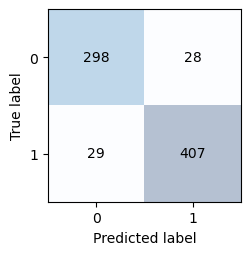

In [70]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i, j],
                va = 'center', ha = 'center')
        
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## Optymalizacja dokładności (precision) i wycofania (recall) modelu klasyfikacji

Zarówno błąd predykcji (ERR), jak i dokładność (ACC) dostarczają ogólnych informacji o tym, ile przykładów zostało błędnie sklasyfikowanych. Błąd można rozumieć jako sumę wszystkich fałszywych przewidywań podzieloną przez liczbę przez liczbę całkowitych przewidywań, a dokładność jest obliczana jako suma poprawnych przewidywań podzielona przez całkowitą liczbę przewidywań. podzielona odpowiednio przez całkowitą liczbę przewidywań:
$$ ERR =  \frac{FP + FN}{FP + FN + TP + TN}$$ 

Dokładność predykcji można następnie obliczyć bezpośrednio na podstawie błędu:
$$ ACC = \frac{TP + TN}{FP + FN + TP + TN} = 1 - ERR $$

**Współczynnik wyników prawdziwie pozytywnych (True Positive Rate)** i **współczynnik wyników fałszywie pozytywnych (False Positive Rate)** to wskaźniki wydajności, które są szczególnie przydatne w przypadku problemów z niezrównoważonymi klasami:
$$ FPR = \frac{FP}{N} = \frac{FP}{FP+TN}$$
$$ TPR = \frac{TP}{P} = \frac{TP}{FN + TP}$$

Wskaźniki wydajności **precyzji (PRE)** i **wycofania (REC)** są powiązane z tymi wskaźnikami TP i TN, i w rzeczywistości REC jest synonimem TPR:

$$ REC = TPR = \frac{TP}{P} = \frac{TP}{FN + TP} $$

Innymi słowy, przywołanie określa ilościowo, ile odpowiednich rekordów (pozytywnych) zostało przechwyconych jako takie (prawdziwe pozytywne). Precyzja określa, ile rekordów przewidywanych jako istotne (suma prawdziwych i fałszywych wyników pozytywnych) jest faktycznie istotnych (prawdziwe wyniki pozytywne):

$$ PRE + \frac{TP}{TP + FP}$$

Aby zrównoważyć wady i zalety optymalizacji PRE i REC, stosuje się średnią harmoniczną PRE i REC tak zwany wynik F1:

$$ F1 = 2 \frac{PRE \times REC}{PRE + REC}$$

Miarą podsumowującą macierz pomyłek jest MCC. MCC oblicza się w następujący sposób:
$$ MCC = \frac{TP \times TN - FP \times FN}{\sqrt{(TP + FP)(TP + FN)(TP + FP)(TN + FN)}}$$


W przeciwieństwie do PRE, REC i wyniku F1, MCC mieści się w zakresie od -1 do 1 i uwzględnia wszystkie elementy macierzy pomyłek - na przykład wynik F1 nie obejmuje TN.

Chociaż wartości MCC są trudniejsze do zinterpretowania niż wynik F1, jest on uważany za lepszy wskaźnik, jak opisano w poniższym artykule: The advantages of the Matthews correlation coefficient (MCC) over F1 score and accuracy in binary classification evaluation autorstwa D. Chicco i G. Jurman, BMC Genomics. s. 281-305, 2012, https://bmcgenomics.biomedcentral.com/articles/10.1186/s1 864-019-6413-7. 

Wszystkie te metryki punktacji są zaimplementowane w scikit-learn i mogą być importowane z modułu sklearn. metrics, jak pokazano w poniższym fragmencie:

In [71]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

pre_val = precision_score(y_true = y_test, y_pred = y_pred)
print(f'Precision: {pre_val}')

rec_val = recall_score(y_true = y_test, y_pred = y_pred)
print(f'Recall: {rec_val}')

f1_val = f1_score(y_true = y_test, y_pred = y_pred)
print(f'F1: {f1_val}')

mcc_val = matthews_corrcoef(y_true = y_test, y_pred = y_pred)
print(f'MCC: {mcc_val:.3f}')

Precision: 0.9356321839080459
Recall: 0.9334862385321101
F1: 0.9345579793340987
MCC: 0.847


Co więcej, możemy użyć innej metryki punktacji niż dokładność w GridSearchCV poprzez parametr scoring parametr.

In [72]:
from sklearn.metrics import make_scorer
c_gamma_range = [0.01, 0.1, 1.0, 10.0]
param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
               {'svc__C': c_gamma_range,
                'svc__gamma': c_gamma_range,
                'svc__kernel': ['rbf']}]
scorer = make_scorer(f1_score, pos_label = 0)
gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = scorer,
                  cv = 2)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9204763085497031
{'svc__C': 10.0, 'svc__kernel': 'linear'}


## Krzywa ROC

Krzywe ROC - ang.Receiver operating characteristic (ROC) przydatnymi narzędziami do wyboru modeli do klasyfikacji na podstawie ich wydajności w odniesieniu do FPR i TPR, które są obliczane przez przesunięcie progu decyzyjnego klasyfikatora.

Przekątna wykresu ROC może być interpretowana jako losowe zgadywanie, a modele klasyfikacji, które spadają poniżej przekątnej, są uważane za gorsze niż losowe zgadywanie. 

Idealny klasyfikator znalazłby się w lewym górnym rogu wykresu z TPR równym 1 i FPR równym 0. Na podstawie krzywej ROC możemy następnie obliczyć tak zwany obszar ROC pod krzywą (ROC AUC), aby scharakteryzować wydajność modelu klasyfikacji.

Wykonując poniższy przykład kodu, wykreślimy krzywą ROC klasyfikatora, który wykorzystuje tylko dwie cechy ze zbioru danych, aby przewidzieć, czy ryż jest klasy Cammeo, czy Osmancik. Chociaż zamierzamy użyć tego samego pipeline'u regresji logistycznej, który zdefiniowaliśmy wcześniej, tym razem używamy tylko dwóch cech. Ma to na celu uczynienie zadania klasyfikacji trudniejszym dla klasyfikatora, poprzez wstrzymanie przydatnych informacji zawartych w innych cechach, tak aby wynikowa krzywa ROC stała się bardziej interesująca wizualnie. Z podobnych powodów zmniejszamy również liczbę podziałów w walidatorze StratifiedKFold do trzech. 

Kod wygląda następująco:

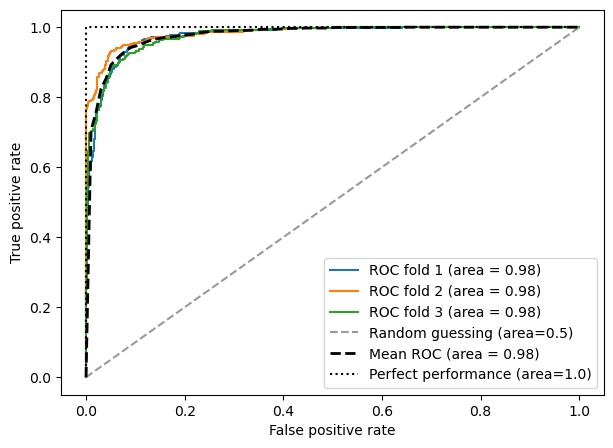

In [73]:
from sklearn.metrics import roc_curve, auc
from numpy import interp
pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components = 2),
    LogisticRegression(penalty = 'l2', random_state = 1,
                       solver = 'lbfgs', C = 100.0)
)
X_train2 = X_train[:, [1, 2]]
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
     probas = pipe_lr.fit(
          X_train2[train],
          y_train[train]).predict_proba(X_train2[test])
     fpr, tpr, thresholds = roc_curve(y_train[test],
                                      probas[:, 1],
                                      pos_label=1)
     mean_tpr += interp(mean_fpr, fpr, tpr)
     mean_tpr[0] = 0.0
     roc_auc = auc(fpr, tpr)
     plt.plot(fpr,
              tpr,
              label=f'ROC fold {i+1} (area = {roc_auc:.2f})')
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing (area=0.5)')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance (area=1.0)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()

W kodzie użyliśmy znanej już klasy `StratifiedKFold` z `scikit-learn` i obliczyliśmy wydajność `ROC` klasyfikatora `LogisticRegression` w naszym potoku `pipe_lr` przy użyciu funkcji `roc_curve` z modułu `sklearn.metrics` oddzielnie dla każdej iteracji. Ponadto interpolowaliśmy średnią krzywą `ROC` z trzech zagięć za pomocą funkcji `interp`, którą zaimportowaliśmy z `NumPy` i obliczyliśmy obszar pod krzywą za pomocą funkcji `AUC`.

Wynikowa krzywa `ROC` wskazuje, że występuje duża zbieżność między różnymi podziałami, a średnia wartość ROC AUC (0,98) mieści się pomiędzy idealnym wynikiem (1,0) a losowym zgadywaniem (0,5).

Zauważmy, że jeśli interesuje nas tylko wynik `ROC AUC`, możemy również bezpośrednio zaimportować funkcję `roc_auc_score` z podmodułu `sklearn.metrics`, która może być używana podobnie do innych funkcji punktacji (na przykład `precision_score`).

Raportowanie wydajności klasyfikatora jako `ROC AUC`` może dostarczyć dalszych informacji na temat wydajności klasyfikatora w odniesieniu do niezrównoważonych próbek.

Jednakże, podczas gdy wynik dokładności może być interpretowany jako pojedynczy punkt odcięcia na krzywej `ROC`, A. P. Bradley wykazał, że wskaźniki `ROC AUC` i dokładności w większości zgadzają się ze sobą: The Use of the Area Under the ROC Curve in the Evaluation of Machine Learning Algorithms by A. P. Bradley, Pattern Recognition, 30(7): 1145-1159, 1997, https://reader.elsevier.com/reader/sd/pii/S0031320396001422

# PCA

Inicjalizacja tranformatora PCA i estymatora regresji logistycznej

In [74]:
pca = PCA(n_components = 2)
lr = LogisticRegression(multi_class = 'ovr',
                        random_state = 1,
                        solver = 'lbfgs')

Redukcja wymiarów

In [75]:
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

Dopasowywanie modelu regresji logistycznej do zrredukowanego zbioru danych

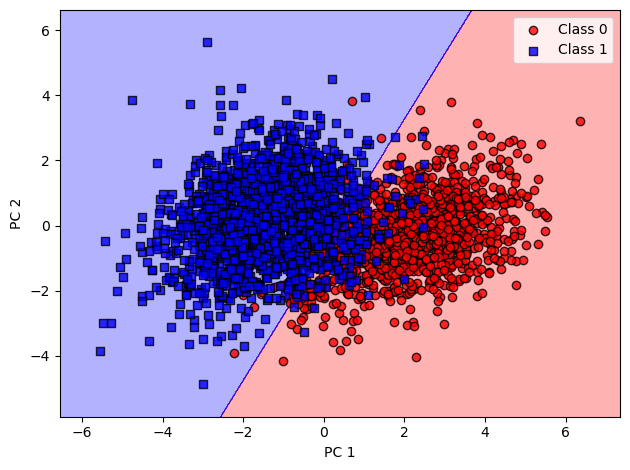

In [76]:
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier = lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

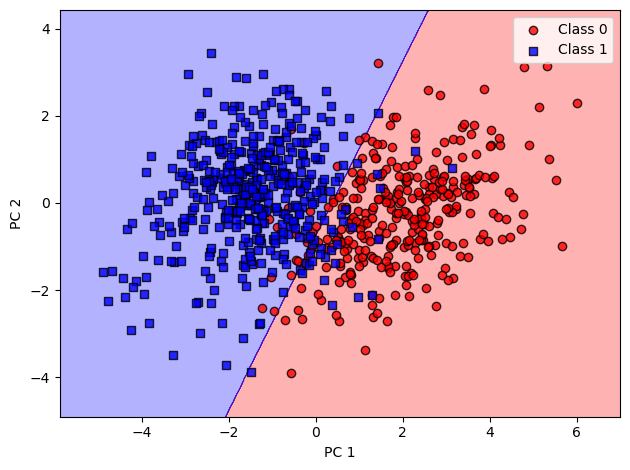

In [77]:
plot_decision_regions(X_test_pca, y_test, classifier = lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

# LDA

In [78]:
# lda = LDA(n_components=2)
# X_train_lda = lda.fit_transform(X_train_std, y_train)
# lr = LogisticRegression(multi_class='ovr', random_state=1,
#                         solver='lbfgs')
# lr = lr.fit(X_train_lda, y_train)
# plot_decision_regions(X_train_lda, y_train, classifier=lr)
# plt.xlabel('LD 1')
# plt.ylabel('LD 2')
# plt.legend(loc='lower left')
# plt.tight_layout()
# plt.show()


In [79]:
# X_test_lda = lda.transform(X_test_std)
# plot_decision_regions(X_test_lda, y_test, classifier=lr)
# plt.xlabel('LD 1')
# plt.ylabel('LD 2')
# plt.legend(loc='lower left')
# plt.tight_layout()
# plt.show()

# SVM

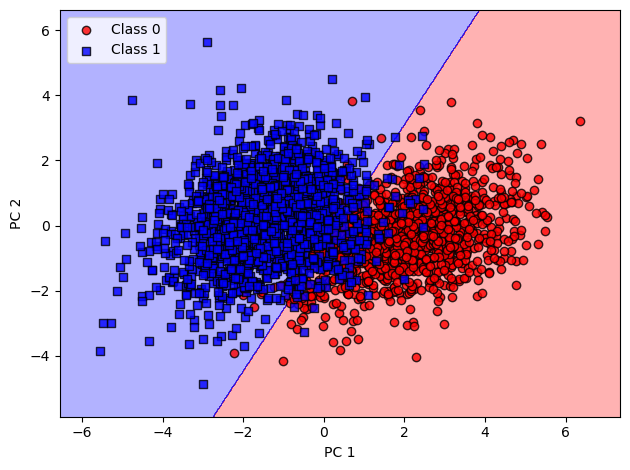

In [83]:
svm = SVC(kernel = 'linear', C = 1.0, random_state = 1)
svm.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca,
                      y_train,
                      classifier = svm)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()


# knn

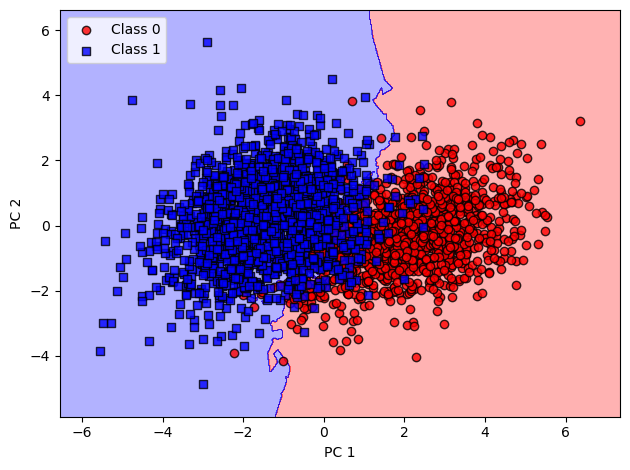

In [86]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, p=2,
                            metric='minkowski')
knn.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train,
                      classifier=knn)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()